In [2]:
# matlotlib inline plotting
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import tensorflow as tf

from IPython.display import display

import seaborn as sns

# Load dataset

SP500_historical.csv - data contains returns for the S&P500 and VIX index going back over 23 years

**Source**: Yahoo Finance

In [4]:
dataset = pd.read_csv("data/SP500_historical.csv", header=0)
print ("Number of data points:", len(dataset))

Number of data points: 5962


In [5]:
print (list(dataset))

['Date', 'SP_Open', 'SP_High', 'SP_Low', 'SP_Close', 'SP_Volume', 'Vix_Open', 'Vix_High', 'Vix_Low', 'Vix_Close']


In [6]:
dataset.head(10)

,Date,SP_Open,SP_High,SP_Low,SP_Close,SP_Volume,Vix_Open,Vix_High,Vix_Low,Vix_Close
0,9/29/16,2168.90,2172.67,2145.20,2151.13,4249220000,12.53,15.69,12.14,14.02
1,9/28/16,2161.85,2172.40,2151.79,2171.37,3891460000,12.90,13.57,12.24,12.39
2,9/27/16,2146.04,2161.13,2141.55,2159.93,3437770000,13.36,14.76,12.97,13.10
3,9/26/16,2158.54,2158.54,2145.04,2146.10,3216170000,13.26,14.63,13.26,14.50
4,9/23/16,2173.29,2173.75,2163.97,2164.69,3317190000,12.00,12.58,11.93,12.29
5,9/22/16,2170.94,2179.99,2170.94,2177.18,3552830000,13.39,13.39,11.76,12.02
6,9/21/16,2144.58,2165.11,2139.57,2163.12,3712090000,15.07,15.65,12.98,13.30
7,9/20/16,2145.94,2150.80,2139.17,2139.76,3140730000,14.98,16.09,14.69,15.92
8,9/19/16,2143.99,2153.61,2135.91,2139.12,3163000000,15.14,15.96,14.60,15.53
9,9/16/16,2146.48,2146.48,2131.20,2139.16,5014360000,16.41,17.10,15.28,15.37


In [7]:
dataset['Date'] = pd.to_datetime(dataset['Date'])

In [8]:
dataset.head()

,Date,SP_Open,SP_High,SP_Low,SP_Close,SP_Volume,Vix_Open,Vix_High,Vix_Low,Vix_Close
0,2016-09-29,2168.90,2172.67,2145.20,2151.13,4249220000,12.53,15.69,12.14,14.02
1,2016-09-28,2161.85,2172.40,2151.79,2171.37,3891460000,12.90,13.57,12.24,12.39
2,2016-09-27,2146.04,2161.13,2141.55,2159.93,3437770000,13.36,14.76,12.97,13.10
3,2016-09-26,2158.54,2158.54,2145.04,2146.10,3216170000,13.26,14.63,13.26,14.50
4,2016-09-23,2173.29,2173.75,2163.97,2164.69,3317190000,12.00,12.58,11.93,12.29


#### Visualizations

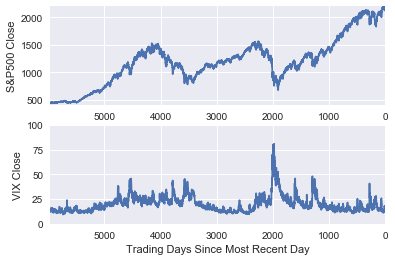

In [9]:
plot_data = dataset.SP_Close
plot_data_VIX = dataset.Vix_Close

f, axes = plt.subplots(2, 1)

axes[0].axis([5962,0,400,2200])
axes[0].plot(plot_data)
axes[0].set_ylabel('S&P500 Close')
#axes[0].set_yticks([400,800,1200,1600,2000,2400])

axes[1].axis([5962,0,0,100])
axes[1].plot(plot_data_VIX)
axes[1].set_ylabel('VIX Close')
plt.xlabel('Trading Days Since Most Recent Day')
plt.savefig('../figs/trading_close.png')

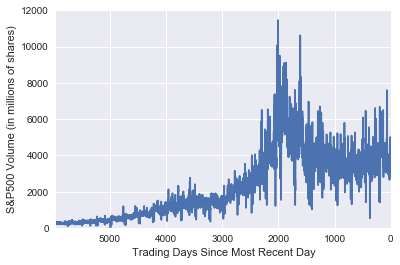

In [10]:
plot_data_Volume = dataset.SP_Volume / 1000000

plt.axis([5962,0,14,12000])
plt.plot(plot_data_Volume)
plt.ylabel('S&P500 Volume (in millions of shares)')
plt.xlabel('Trading Days Since Most Recent Day')
plt.savefig('../figs/volume.png')

## Create set of Features

#### Calculate the 'Break_Coming' feature, which is a measure of whether the market will close for a break on the next day


In [11]:
dataset['Days_Since_Open'] = (dataset['Date'] - dataset['Date'].shift(-1))
dataset['Days_Since_Open'] = dataset['Days_Since_Open'].astype('timedelta64[D]')

dataset['Break_Coming'] = dataset['Days_Since_Open'].shift(1).apply(lambda x: 1 if x > 1 else 0)
#dataset.Break_Coming.fillna(0, inplace=True)

#### Calculate the 'Overnight_Return' feature and the 'Overnight_VIX' feature, which measures whether the VIX has opened up or down relative to previous day


In [12]:
dataset['Overnight_Return'] = dataset['SP_Open'] / dataset['SP_Close'].shift(-1) - 1


#### Calculate the 'No_Overnight_Change' value. This is not a feature, but was used to identify unreliable data rows

In [13]:
dataset['No_Overnight_Change'] = dataset['Overnight_Return'].apply(lambda v : 1 if v == 0.00 else 0)

In [14]:
dataset['Overnight_VIX'] = dataset['Vix_Open'] / dataset['Vix_Close'].shift(-1) - 1

#### Calculate the 'O2O' feature, which compares the current opening price to the previous day

In [15]:
dataset['O2O'] = dataset['SP_Open'] / dataset['SP_Open'].shift(-1) - 1

#### Calculate 11 different trailing return features, 9 based on the S&P500 data and 2 based on VIX data


In [16]:
dataset['1d_Ret'] = dataset['SP_Close'].shift(-1) / dataset['SP_Close'].shift(-2) - 1
dataset['2d_Ret'] = dataset['SP_Close'].shift(-1) / dataset['SP_Close'].shift(-3) - 1
dataset['3d_Ret'] = dataset['SP_Close'].shift(-1) / dataset['SP_Close'].shift(-4) - 1
dataset['4d_Ret'] = dataset['SP_Close'].shift(-1) / dataset['SP_Close'].shift(-5) - 1
#1 week of trading has typically 5 days
dataset['5d_Ret'] = dataset['SP_Close'].shift(-1) / dataset['SP_Close'].shift(-6) - 1
#1 month of trading has typically 21 days
dataset['21d_Ret'] = dataset['SP_Close'].shift(-1) / dataset['SP_Close'].shift(-22) - 1
#3 months of trading
dataset['63d_Ret'] = dataset['SP_Close'].shift(-1) / dataset['SP_Close'].shift(-64) - 1
#6 months of trading
dataset['126d_Ret'] = dataset['SP_Close'].shift(-1) / dataset['SP_Close'].shift(-127) - 1
#9 months of trading
dataset['189d_Ret'] = dataset['SP_Close'].shift(-1) / dataset['SP_Close'].shift(-190) - 1
#12 months of trading
dataset['252d_Ret'] = dataset['SP_Close'].shift(-1) / dataset['SP_Close'].shift(-253) - 1


dataset['1d_VIX'] = dataset['Vix_Close'].shift(-1) / dataset['Vix_Close'].shift(-2) - 1
dataset['5d_VIX'] = dataset['Vix_Close'].shift(-1) / dataset['Vix_Close'].shift(-6) - 1

#### Calculate 2 different trailing volume features, which measure whether the last day's volume is above or below recent averages

In [17]:
dataset['1d_Rel_Vol'] = dataset['SP_Volume'].shift(-1) / (
    dataset['SP_Volume'].rolling(window=4).mean().shift(-5)) - 1

dataset['5d_Rel_Vol'] = dataset['SP_Volume'].rolling(window=5).mean().shift(-5) / (
    dataset['SP_Volume'].rolling(window=21).mean().shift(-26)) - 1

#### Calculate the '1d_PtT' feature, which measure how much the S&P500 moved from high to low values on the previous trading day

#### Calculate the '1d_VIX_PtT' feature, which measure how much the VIX moved from high to low values on the previous trading day

In [18]:
dataset['1d_PtT'] = (dataset['SP_High'].shift(-1) - dataset['SP_Low'].shift(-1)) / (0.5*(
        dataset['SP_Open'].shift(-1) + dataset['SP_Close'].shift(-1)))

dataset['1d_VIX_PtT'] = (dataset['Vix_High'].shift(-1) - dataset['Vix_Low'].shift(-1)) / (0.5*(
        dataset['Vix_Open'].shift(-1) + dataset['Vix_Close'].shift(-1)))

#### Calculate the 'Intraday_Increase' label, which is ultimately what the machine learner should predict, and as is a measure of whether the S&P500 increased on a given day (value = 1) or not (value = 0)

In [19]:
dataset['Intraday_Increase'] = (dataset['SP_Close'] - dataset['SP_Open']).apply(lambda v: 1 if v > 0 else 0)

Delete those rows that have N/A values (e.g. one cannot do a 252 day trailing return if there are fewer than 252 days trailing a given data point)

In [20]:
noNA_data = dataset.dropna()
print ("Number of data points:", len(noNA_data))

Number of data points: 5709


Delete rows where 'No_Overnight_Change' is equal to 1: these are points where the opening value is **identical** to the previous closing data, which likely reflects missing true opening prices: the chances of the market opening at the identical level as the previous close are slim to none. Most of these points came from the older portion of the data set. There were almost no points like this in the most recent 10 years!

In [21]:
validated_data = noNA_data[noNA_data.No_Overnight_Change != 1]
print ("Number of data points:", len(validated_data))

validated_data.to_csv("data/curated_all_fields_dataset.csv", sep='\t')

Number of data points: 2678


Drop columns that would allow the machine learning algorithm to 'know the future': for example, it cannot be trained using SP_Close for any given day, since that would trivially allow it to calculate whether the market closed up on any given day. It can only be provided information that one would know at the start of the day (i.e. data from previous days and the opening data). This rules out High, Low and Close values for the market and the VIX and also the market volume for any given day. 

Finally, we will limit the analysis to relative returns, not absolute values of the indeces, given that the stock market tends to increase with time and hence comparing the absolute value of the S&P500 over a 20+ year period will not be helpful.

In summary, the final data set will consist of only the **21 calculated features** and the 1 label, for the 2,678 validated data rows.

In [22]:
# Print the column headers of the current data set
print (list(validated_data))

['Date', 'SP_Open', 'SP_High', 'SP_Low', 'SP_Close', 'SP_Volume', 'Vix_Open', 'Vix_High', 'Vix_Low', 'Vix_Close', 'Days_Since_Open', 'Break_Coming', 'Overnight_Return', 'No_Overnight_Change', 'Overnight_VIX', 'O2O', '1d_Ret', '2d_Ret', '3d_Ret', '4d_Ret', '5d_Ret', '21d_Ret', '63d_Ret', '126d_Ret', '189d_Ret', '252d_Ret', '1d_VIX', '5d_VIX', '1d_Rel_Vol', '5d_Rel_Vol', '1d_PtT', '1d_VIX_PtT', 'Intraday_Increase']


In [23]:
# Drop all but columns that are not one of the 21 features or the label
data = validated_data.drop(validated_data.columns[[0,1,2,3,4,5,6,7,8,9,13]], axis=1)

In [24]:
# Print the headers of 'data', to validate that the correct columns were dropped
print (list(data))

['Days_Since_Open', 'Break_Coming', 'Overnight_Return', 'Overnight_VIX', 'O2O', '1d_Ret', '2d_Ret', '3d_Ret', '4d_Ret', '5d_Ret', '21d_Ret', '63d_Ret', '126d_Ret', '189d_Ret', '252d_Ret', '1d_VIX', '5d_VIX', '1d_Rel_Vol', '5d_Rel_Vol', '1d_PtT', '1d_VIX_PtT', 'Intraday_Increase']


#### Save curated dataset

In [25]:
data.to_csv("data/curated_dataset.csv", sep='\t')

In [26]:
display(data.describe())

,Days_Since_Open,Break_Coming,Overnight_Return,Overnight_VIX,O2O,1d_Ret,2d_Ret,3d_Ret,4d_Ret,5d_Ret,...,126d_Ret,189d_Ret,252d_Ret,1d_VIX,5d_VIX,1d_Rel_Vol,5d_Rel_Vol,1d_PtT,1d_VIX_PtT,Intraday_Increase
count,2678.000000,2678.000000,2678.000000,2678.000000,2678.000000,2678.000000,2678.000000,2678.000000,2678.000000,2678.000000,...,2678.000000,2678.000000,2678.000000,2678.000000,2678.000000,2678.000000,2678.000000,2678.000000,2678.000000,2678.000000
mean,1.444735,0.210978,-0.000022,0.005908,0.000251,0.000260,0.000511,0.000612,0.000847,0.001112,...,0.029453,0.043546,0.059645,0.002947,0.010982,0.008819,0.010441,0.013533,0.085928,0.547050
std,0.875799,0.408079,0.001603,0.045081,0.012292,0.012973,0.017303,0.020321,0.023078,0.025472,...,0.124501,0.152028,0.173760,0.074680,0.155039,0.181773,0.156196,0.011147,0.050513,0.497874
min,1.000000,0.000000,-0.014194,-0.300366,-0.087119,-0.090350,-0.124174,-0.139059,-0.172221,-0.183401,...,-0.464658,-0.513279,-0.488228,-0.295726,-0.426630,-0.832518,-0.669690,0.002009,0.014966,0.000000
25%,1.000000,0.000000,-0.000407,-0.016031,-0.004256,-0.004494,-0.006988,-0.007946,-0.009736,-0.010137,...,-0.027543,-0.017576,-0.004349,-0.040230,-0.079295,-0.090512,-0.083042,0.006880,0.053312,0.000000
50%,1.000000,0.000000,-0.000008,0.000820,0.000642,0.000569,0.001294,0.002182,0.002630,0.003111,...,0.043190,0.063683,0.089677,-0.005022,-0.009048,-0.005982,-0.000374,0.010471,0.074426,1.000000
75%,1.000000,0.000000,0.000500,0.024785,0.005425,0.005642,0.008789,0.010729,0.012735,0.014399,...,0.097326,0.134731,0.163089,0.036402,0.072292,0.090148,0.089807,0.016249,0.103512,1.000000
max,5.000000,1.000000,0.015046,0.510725,0.106712,0.115800,0.132064,0.139480,0.179735,0.191112,...,0.502372,0.634783,0.685735,0.642152,2.129032,2.045477,0.947982,0.107198,0.734623,1.000000


In [27]:
# split features and labels:
X = data.drop('Intraday_Increase', axis=1)
y = pd.DataFrame(data['Intraday_Increase'])

# Summarize the label data
display(y.describe())

,Intraday_Increase
count,2678.000000
mean,0.547050
std,0.497874
min,0.000000
25%,0.000000
50%,1.000000
75%,1.000000
max,1.000000
